# Benchmarking Protein Structure Prediction methods

##### In this notebook we compare the jensen shannon distance between the structural predictions of PEP2D, JPred, PHYRE and AlphaFold2 against the experimental benchmark obtained in PDBe to determine the best performing model

In [3]:
import pandas as pd
from collections import Counter
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import tensorflow as tf
from scipy.spatial.distance import jensenshannon 
from numpy import asarray
import mpltern as mp

### Calculating the secondary structure percentage for the predictions of JPred, Phyre and AlphaFold (Not necessary for PEP2D as the percentage is part of its output)

In [5]:
#charging datasets
jpred_oneid_df=pd.read_csv('./pdb/jpred/jpred_oneid.tsv', sep='\t', names=['pdb_id','sequence','secondary_structure', 'len'])
phyre_oneid=pd.read_csv('./pdb/phyre/phyreoneid.tsv', sep='\t', names=['pdb_id','sequence','secondary_structure', 'len'])
alphafold = pd.read_csv('./pdb/alphafold/summary/alphafold_ss.tsv', sep='\t', names=['pdb_id','len','sequence','secondary_structure'])

In [14]:
alphafold

,pdb_id,len,sequence,secondary_structure,helix%,strand%,coil%
0,1avf,26,AVVKVPLKKFKSIRETMKEKGLLGEF,CCCCCCCCCCCCHHHHHHHHCCCCCC,30.769,0.000,69.231
1,1bh4,30,CGESCVWIPCISAALGCSCKNKVCYRNGIP,CCEECCCCCCCCHHHCCEEECCEEEECCEC,10.000,33.333,56.667
2,1bk8,50,LCNERPSQTWSGNCGNTAHCDKQCQDWEKASHGACHKRENHWKCFC...,CCEEEECCCCCCCCCCHHHHHHHHHHHHCCCEEEEEEECCEEEEEE...,24.000,38.000,38.000
3,1bnb,38,APLSCGRNGGVCIPIRCPVPMRQIGTCFGRPVKCCRSW,CHHHHHHHCCEEECCCCCCCCEEEEEECCCCEEEEECC,18.421,36.842,44.737
4,1cix,44,YSRCQLQGFNCVVRSYGLPTIPCCRGLTCRSYFPGSTYGRCQRY,CCCCECCCEEEECCCCCCCCCCECCCEEEEECCCCCCEEEEEEC,0.000,38.636,61.364
...,...,...,...,...,...,...,...
256,7c2p,47,RTCESQSHKFKGPCLRASNCANVCKTEGFHGGKCRGFRRRCFCTKHC,CEEEEECCCCCCCCCCHHHHHHHHHHHCCCEEEEECCCCEEEEEEEC,23.404,36.170,40.426
257,7c31,47,RVCESQSHKFEGACMGDHNCALVCRNEGFSGGKCKGLRRRCFCTKLC,CEEEEECCCCCCCCCCHHHHHHHHHHHCCCEEEEECCCCEEEEEEEC,23.404,36.170,40.426
258,7k7x,29,GLPVCGETCVGGTCNTPGCVCSWPVCTRN,CCCEEEEECCCCCCCCCCCEEECCEEECC,0.000,37.931,62.069
259,7kpd,29,AIPCGESCVYIPCISVVIGCSCRNKVCYR,CCEEEEECCCCCCCCHHHCCEEECCEEEC,10.345,37.931,51.724


In [10]:
def ss_percentage(df, column):
    '''This function calculates ss percentage (C,H,E) from string
        DataFrame must contain a column named 'len' with the length of all sequences
        param: df=dataframe containing ss calculations
        param: column= column corresponding to ss
        return: none (dataframe updated with ss%) 
    '''
    ss_list=df[column].tolist()
    helix_count=[]
    coil_count=[]
    strand_count=[]
    
    for i in range(len(ss_list)):
        coil_count.append(ss_list[i].count('C'))
        helix_count.append(ss_list[i].count('H'))
        strand_count.append(ss_list[i].count('E'))
    
    helix_percent=[]
    coil_percent=[]
    strand_percent=[]
    len_df=df['len'].tolist()
    
    for j in range(len(coil_count)):
        coil_percent.append(round(coil_count[j]/len_df[j]*100, 3))
        helix_percent.append(round(helix_count[j]/len_df[j]*100, 3))
        strand_percent.append(round(strand_count[j]/len_df[j]*100, 3))
    
    df['helix%']=helix_percent
    df['strand%']=strand_percent
    df['coil%']=coil_percent
    
    return None


In [16]:
#calculating percentage
ss_percentage(df=jpred_oneid_df, column='secondary_structure')
ss_percentage(df=phyre_oneid, column='secondary_structure')
ss_percentage(df=alphafold, column='secondary_structure')

### Saving DF with calculated percentages


In [12]:
#phyre_oneid.to_csv('./pdb/phyre/oneid_prc.csv')
#jpred_oneid_df.to_csv('./pdb/jpred/oneid_prc.csv')
#alphafold.to_csv('./pdb/alphafold/alphafold_prc.csv')

In [35]:
pep2d_oneid =pd.read_csv('./pdb/pep2d/pep2d_prc.csv', index_col=0)
phyre_oneid_df=pd.read_csv('./pdb/phyre/phyre_prc.csv', index_col=0)
jpred_oneid_df=pd.read_csv('./pdb/jpred/jpred_prc.csv', index_col=0)
alphafold_df = pd.read_csv('./pdb/alphafold/alphafold_prc.csv', index_col=0)

In [29]:
#Reading experimental reference
pdbe_oneid=pd.read_csv('./pdb/pdbe/oneid_pdbe.csv')

In [30]:
pdbe_oneid

,pdb_id,sequence,length,helix_count,strand_count,coil_count,helix%,strand%,coil%
0,1avf,AVVKVPLKKFKSIRETMKEKGLLGEF,26,10,7,9,38.462,26.923,34.615
1,1bh4,CGESCVWIPCISAALGCSCKNKVCYRNGIP,30,11,0,19,36.667,0.000,63.333
2,1bk8,LCNERPSQTWSGNCGNTAHCDKQCQDWEKASHGACHKRENHWKCFC...,50,11,18,21,22.000,36.000,42.000
3,1bnb,APLSCGRNGGVCIPIRCPVPMRQIGTCFGRPVKCCRSW,38,0,15,23,0.000,39.474,60.526
4,1cix,YSRCQLQGFNCVVRSYGLPTIPCCRGLTCRSYFPGSTYGRCQRY,44,0,11,33,0.000,25.000,75.000
...,...,...,...,...,...,...,...,...,...
256,7c2p,RTCESQSHKFKGPCLRASNCANVCKTEGFHGGKCRGFRRRCFCTKHC,47,11,17,19,23.404,36.170,40.426
257,7c31,RVCESQSHKFEGACMGDHNCALVCRNEGFSGGKCKGLRRRCFCTKLC,47,12,17,18,25.532,36.170,38.298
258,7k7x,GLPVCGETCVGGTCNTPGCVCSWPVCTRN,29,0,0,29,0.000,0.000,100.000
259,7kpd,AIPCGESCVYIPCISVVIGCSCRNKVCYR,29,5,11,13,17.241,37.931,44.828


# KL Divergence & Shannon Entropy

### Calculating JSD between results and experimental reference

In [31]:
def list_to_array(df,column):
    your_list=df[column].tolist()
    your_list=asarray([round(i/100,4) for i in your_list])
    return your_list

In [37]:
jpredhelix=list_to_array(df=jpred_oneid_df, column='helix%')
jpredstrand=list_to_array(df=jpred_oneid_df, column='strand%')
jpredcoil=list_to_array(df=jpred_oneid_df, column='coil%')

phyrehelix=list_to_array(df=phyre_oneid_df, column='helix%')
phyrestrand=list_to_array(df=phyre_oneid_df, column='strand%')
phyrecoil=list_to_array(df=phyre_oneid_df, column='coil%')

pep2dhelix=list_to_array(df=pep2d_oneid, column='helix%')
pep2dstrand=list_to_array(df=pep2d_oneid, column='sheet%')
pep2dcoil=list_to_array(df=pep2d_oneid, column='coil%')

pdbehelix=list_to_array(df=pdbe_oneid, column='helix%')
pdbestrand=list_to_array(df=pdbe_oneid, column='strand%')
pdbecoil=list_to_array(df=pdbe_oneid, column='coil%')

alphafoldhelix=list_to_array(df=alphafold_df, column='helix%')
alphafoldstrand=list_to_array(df=alphafold_df, column='strand%')
alphafoldcoil=list_to_array(df=alphafold_df, column='coil%')

In [38]:
js_jpred_helix=jensenshannon(p=pdbehelix, q=jpredhelix, base=2)
js_jpred_strand=jensenshannon(p=pdbestrand, q=jpredstrand, base=2)
js_jpred_coil=jensenshannon(p=pdbecoil, q=jpredcoil, base=2)

js_phyre_helix=jensenshannon(p=pdbehelix, q=phyrehelix, base=2)
js_phyre_strand=jensenshannon(p=pdbestrand, q=phyrestrand, base=2)
js_phyre_coil=jensenshannon(p=pdbecoil, q=phyrecoil, base=2)

js_pep2d_helix=jensenshannon(p=pdbehelix, q=pep2dhelix, base=2)
js_pep2d_strand=jensenshannon(p=pdbestrand, q=pep2dstrand, base=2)
js_pep2d_coil=jensenshannon(p=pdbecoil, q=pep2dcoil, base=2)

js_alphafold_helix=jensenshannon(p=pdbehelix, q=alphafoldhelix, base=2)
js_alphafold_strand=jensenshannon(p=pdbestrand, q=alphafoldstrand, base=2)
js_alphafold_coil=jensenshannon(p=pdbecoil, q=alphafoldcoil, base=2)

# Graphs 

In [43]:
# Read the results in a pivot table to facilitate the plotting process
pdb_pep2d=pd.read_csv('./pdb/benchmark/pdb_pep2d.csv')
pdb_jpred=pd.read_csv('./pdb/benchmark/pdb_jpred.csv')
pdb_phyre=pd.read_csv('./pdb/benchmark/pdb_phyre.csv')
pdb_alphafold=pd.read_csv('./pdb/benchmark/pdb_alphafold.csv')

In [44]:
pdb_alphafold

,percentage,type,motif
0,38.462,PDBe,helix
1,36.667,PDBe,helix
2,22.000,PDBe,helix
3,0.000,PDBe,helix
4,0.000,PDBe,helix
...,...,...,...
1561,40.426,AlphaFold,coil
1562,40.426,AlphaFold,coil
1563,62.069,AlphaFold,coil
1564,51.724,AlphaFold,coil


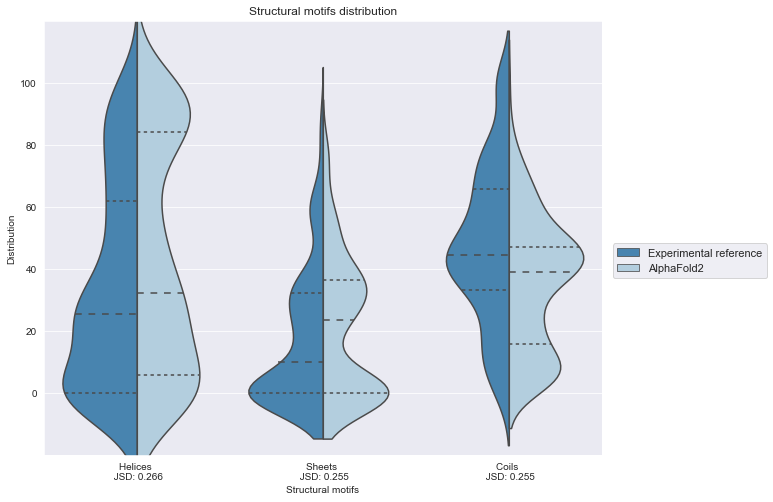

In [46]:
fig=plt.gcf()
fig.set_size_inches(10,8)
g=sns.violinplot(data=pdb_alphafold, y="percentage", x='motif', hue='type', split=True, inner='quartile', palette='Blues_r')
g.set(ylim=(-20,120))
plt.title('Structural motifs distribution')
plt.xlabel('Structural motifs')
plt.ylabel('Distribution')
plt.yticks(np.arange(0,101,20))
sns.set_theme(style="darkgrid")
legend = g.legend(handles=g.legend_.legendHandles, labels=['Experimental reference', 'AlphaFold2'], bbox_to_anchor=(1.01, 0.5), ncol=1)
g.set_xticklabels(['Helices \n JSD: %.3f' % js_alphafold_helix, 'Sheets \n JSD: %.3f' % js_alphafold_strand, 'Coils \n JSD: %.3f' % js_alphafold_coil])
fig.set_tight_layout(False)
plt.savefig('alphafold.pdf', dpi=500, bbox_extra_artists=[legend], bbox_inches='tight')


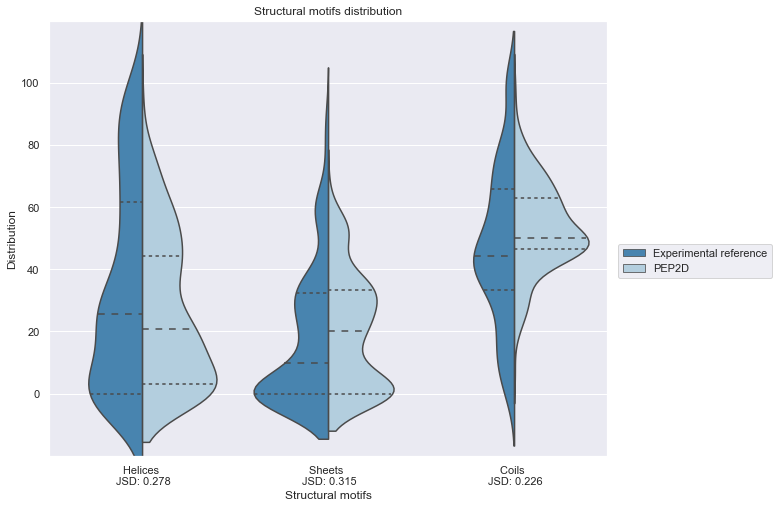

In [55]:
fig=plt.gcf()
fig.set_size_inches(10,8)
g=sns.violinplot(data=pdb_pep2d, y="percentage", x='motif', hue='type', split=True, inner='quartile', palette='Blues_r')
g.set(ylim=(-20,120))
plt.title('Structural motifs distribution')
plt.xlabel('Structural motifs')
plt.ylabel('Distribution')
plt.yticks(np.arange(0,101,20))
sns.set_theme(style="darkgrid")
legend = g.legend(handles=g.legend_.legendHandles, labels=['Experimental reference', 'PEP2D'], bbox_to_anchor=(1.01, 0.5), ncol=1)
g.set_xticklabels(['Helices \n JSD: %.3f' % js_pep2d_helix, 'Sheets \n JSD: %.3f' % js_pep2d_strand, 'Coils \n JSD: %.3f' % js_pep2d_coil])
fig.set_tight_layout(False)
plt.savefig('pep2d.png', dpi=500, bbox_extra_artists=[legend], bbox_inches='tight')

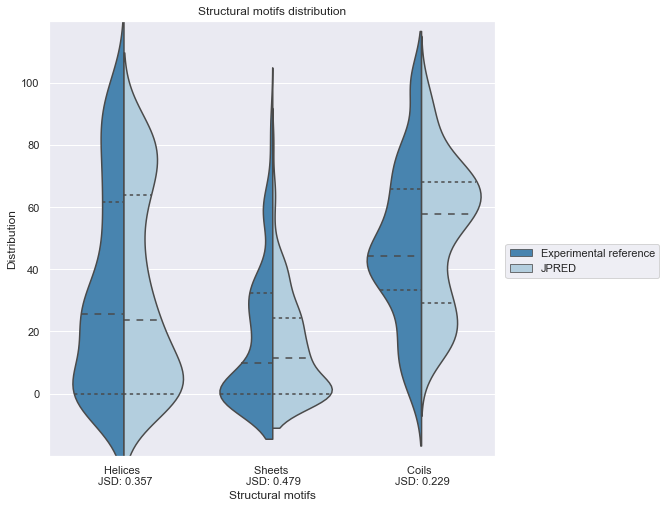

In [56]:
fig=plt.gcf()
fig.set_size_inches(8,8)
g=sns.violinplot(data=pdb_jpred, y="percentage", x='motif', hue='type', split=True, inner='quartile', palette='Blues_r')
g.set(ylim=(-20,120))
plt.title('Structural motifs distribution')
plt.xlabel('Structural motifs')
plt.ylabel('Distribution')
plt.yticks(np.arange(0,101,20))
sns.set_theme(style="darkgrid")
legend = g.legend(handles=g.legend_.legendHandles, labels=['Experimental reference', 'JPRED'], bbox_to_anchor=(1.01, 0.5), ncol=1)
g.set_xticklabels(['Helices \n JSD: %.3f' % js_jpred_helix, 'Sheets \n JSD: %.3f' % js_jpred_strand, 'Coils \n JSD: %.3f' % js_jpred_coil])
fig.set_tight_layout(False)
plt.savefig('JPRED.png', dpi=500, bbox_extra_artists=[legend], bbox_inches='tight')

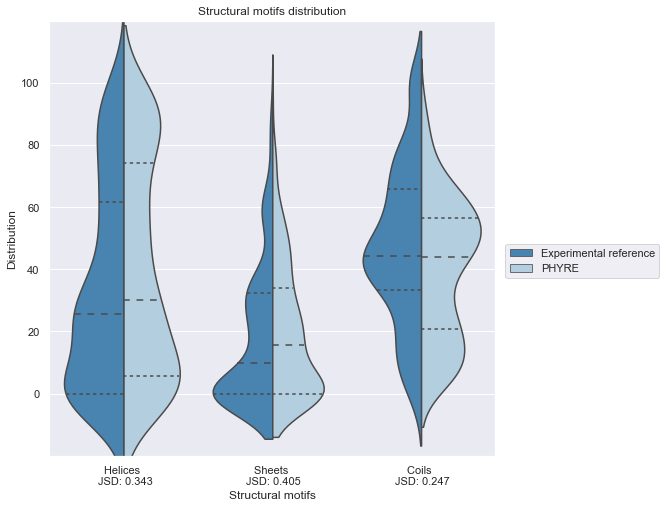

In [47]:
fig=plt.gcf()
fig.set_size_inches(8,8)
g=sns.violinplot(data=pdb_phyre, y="percentage", x='motif', hue='type', split=True, inner='quartile', palette='Blues_r')
g.set(ylim=(-20,120))
plt.title('Structural motifs distribution')
plt.xlabel('Structural motifs')
plt.ylabel('Distribution')
plt.yticks(np.arange(0,101,20))
sns.set_theme(style="darkgrid")
legend = g.legend(handles=g.legend_.legendHandles, labels=['Experimental reference', 'PHYRE'], bbox_to_anchor=(1.01, 0.5), ncol=1)
g.set_xticklabels(['Helices \n JSD: %.3f' % js_phyre_helix, 'Sheets \n JSD: %.3f' % js_phyre_strand, 'Coils \n JSD: %.3f' % js_phyre_coil])
fig.set_tight_layout(False)
plt.savefig('PHYRE.png', dpi=500, bbox_extra_artists=[legend], bbox_inches='tight')